# Ryzyko, zad. 6

W tabeli podane są parametry 3 obligacji o nominale $F = 100$ każda. 

| obligacja | zapadalność $T$ | oprocentowanie $c$ | częstotliwość płatności<br> odsetek $m$ | $YTM$ |
|:-:|:-:|:-:|:-:|:-:|
|$A$|$2$|$3\%$|$1$|$6\%$|
|$B$|$7$|$4\%$|$1$|$6\%$|
|$C$|$18$|$5\%$|$1$|$6\%$|

Skonstruuj 0-kosztowy portfel obligacji (wartosc portfela $V_p(0) = 0$) o zmodyfikowanym
duration $MD = 0$ i dodatniej wypukłości.

Jaka będzie wartość portfela $V_p$ jeśli $YTM$ wszystkich obligacji
* wzrosnie o $75$ bps.,
* spadnie o $75$ bps?

-----------
## Rozwiązanie
Rozpoczniemy od zdefiniowania klas reprezentujących poszczególne obligacje. Takie podejście pozwoli na utworzenie metod dla każdej z nich, pozwalających na rekalkulację ceny, MD oraz convexity przy zmiennej $ytm$.

In [176]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = [12, 8]

class Fixed_Bond():
    """Class representing a fixed coupon bond"""
    
    def __init__(self, T,F,c,m):
        # initialize bond setup
        
        self.T = T # maturity
        self.c = c # coupon rate p.a.
        self.m = m # coupon payments p.a.
        self.F = F # face value
        self.CF_schedule = self.make_CF_schedule(T,F,c,m) # coupon payment schedule
    
    def __repr__(self):
        # display short bond description
        
        description = """Fixed coupon bond with:
         - {}% p.a. coupon, payed {} times per year
         - face value of {}
         - maturing in {} years.""".format(round(self.c*100,2), self.m,self.F, self.T)
        return description
    
    def make_CF_schedule(self, T,F,c,m):
        # create the payment schedule
        
        coupons = np.array([F*c/m for i in range(m*T)]) #array of coupon payments
        coupons[-1] = coupons[-1]+F #add the face value to the last payment  
        
        time = np.array([(i+1)/m for i in range(m*T)]) # prepare the underlying timeline
        
        CF_schedule = pd.DataFrame({'time':time, 'CF':coupons}) # compose a dataframe from timeline & payments
        CF_schedule = CF_schedule.set_index("time") # make time be the index 
        
        return CF_schedule
    
    def price(self, ytm):
        # compute the bond price given the ytm
        
        CF_schedule = self.CF_schedule # download the cashflow schedule
        CF_schedule['PV_factor'] = np.array([(1/(1+ytm/self.m))])**CF_schedule.index # compute pv-factor-weighted cashflows
        
        price = (CF_schedule['CF']*CF_schedule['PV_factor']).sum() # sum them to get the price
        
        return price

    def MD(self,ytm):
        # compute the modified duration of the bond
        
        CF_schedule = self.CF_schedule # download the cashflow schedule
        CF_schedule['PV_factor^(t+1)'] = np.array([(1/(1+ytm/self.m))])**(CF_schedule.index+1/self.m) # compute the pv-factor^(t+1)
        
        MD = 1/self.m*(CF_schedule['CF']*CF_schedule.index*CF_schedule['PV_factor^(t+1)']).sum()/self.price(ytm) # compute the MD
        
        return MD
    
    def C(self,ytm):
        # compute the convexity of the bond
    
        CF_schedule = self.CF_schedule # download the cashflow schedule
        CF_schedule['PV_factor^(t+2)'] = np.array([(1/(1+ytm/self.m))])**(CF_schedule.index+2/self.m) # compute the pv_factor^(t+2)
        
        C = 1/self.m**2*(CF_schedule['CF']*CF_schedule.index*(CF_schedule.index+1/self.m)*CF_schedule['PV_factor^(t+2)']).sum()/self.price(ytm) # compute the convexity
        
        return C
    
    
#### Przykładowa definicja obligacji 8 letniej, o nominale 300, stopie kuponowej 4% z płatnościami 4 razy do roku
Example_Bond_Definition = Fixed_Bond(8,300, 0.04, 4)
print(Example_Bond_Definition)

Fixed coupon bond with:
         - 4.0% p.a. coupon, payed 4 times per year
         - face value of 300
         - maturing in 8 years.


--------
## Wpływ ytm na cenę obligacji

Zdefiniujmy zatem obligacje z zadania i zobaczmy zachowanie ich cen dla różnych $ytm$. Jako że wszystkie obligacje mają kupony płatne raz do roku, z oprocentowaniem niższym niż *ytm*, oczekujemy że wszystkie będą wycenione na dyskoncie. Spodziewamy się, również że najbardziej na zmiany reagować będzie obligacja **C**, z powodu nieporównywalnie dalszej zapadalności. Istotnie, poniższy wykres ilustruje obie te obserwacje.

  Bond  Price at ytm= 6%
0    A         94.499822
1    B         88.835237
2    C         89.172397


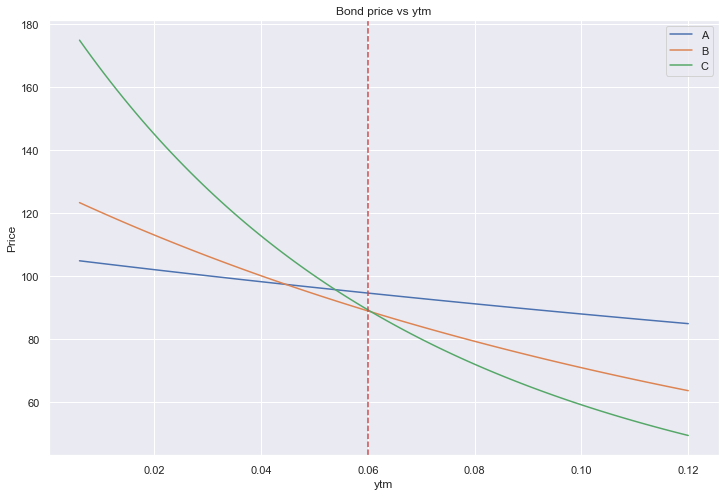

In [186]:
A = Fixed_Bond(2, 100, 0.03, 1)
B = Fixed_Bond(7, 100, 0.04, 1)
C = Fixed_Bond(18,100, 0.05, 1)
Bonds = [A,B,C]


ytm =0.06

#Set the x-axis of ytm values and calculate corresponding bond prices
ytm_range = np.linspace(start = ytm*0.1, stop = ytm*2, num = 100)
prices = [(A.price(ytm_), B.price(ytm_), C.price(ytm_)) for ytm_ in ytm_range]

price_at_ytm = pd.DataFrame({'Bond':['A','B','C'],'Price at ytm= 6%':[Bond.price(ytm) for Bond in Bonds]})
print(price_at_ytm)

#Create the prices vs ytm dataframe and display plot
prices_DataFrame = pd.DataFrame({'ytm':ytm_range,'A':[p[0] for p in prices],'B':[p[1] for p in prices],'C':[p[2] for p in prices]})
prices_DataFrame.set_index('ytm', inplace = True)
prices_DataFrame.plot(title = "Bond price vs ytm")
plt.ylabel('Price')
_= plt.axvline(ytm, c = 'r', linestyle = '--')

Jedną z interpretacji takiego zachowania cen obligacji przypisuje się ich **modified duration** oraz **convexity**. Wartości te można rozumieć jako odpowiednio przeskalowaną pierwszą i drugą pochodną ceny obligacji po *ytm*. Teoria mówi więc, że siłę reakcji ceny na zmiany $ytm$ można opisać za pomocą tych parametrów.

$$ MD(ytm) = -\frac{\text{d}P}{\text{d}ytm}(ytm)\cdot\frac{1}{P(ytm)} $$

$$ C(ytm) = \frac{\text{d}^2P}{\text{d}ytm^2}(ytm)\cdot\frac{1}{P(ytm)} $$


Obserwując duration obliczone w poniższej tabeli można zauważyć, że obligacja **C** ma modified duration na poziomie $11.23$, co jest istotnie większe od MD pozostałych obligacji. Razem z istotnie większą convexity te statystyki powodują mocniejsze nachylenie i wygięcie krzywej widocznej na wykresie.

In [130]:
BondStats_DataFrame = pd.DataFrame({'Bond':['A','B','C'],'MD':[Bond.MD(ytm) for Bond in Bonds], 'C':[Bond.C(ytm) for Bond in Bonds]})
BondStats_DataFrame

,Bond,MD,C
0,A,1.858539,5.233360
1,B,5.837267,42.217721
2,C,11.230540,171.895265


----------------
### Macaulay Duration
Warto wspomnieć o pokrewnej mierze ryzyka stopy procentowej, jaką jest *Macaulay Duration*. Definiowane przez:
$$D_{Mac} = MD\cdot\big(1+\frac{ytm}{m}\big),$$ 

oferuje ciekawą interpretację jako *środek ciężkości* ciągu zdyskontowanych płatności. Prezentujemy ideę tego spojrzenia na bazie obligacji **C** na poniższym wykresie:

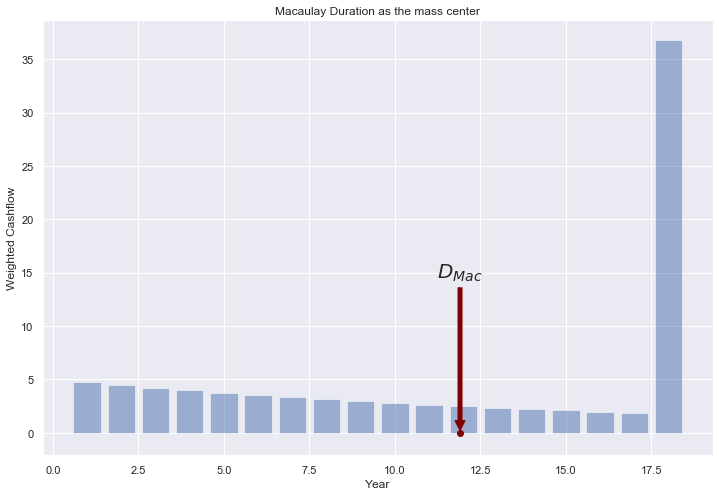

In [201]:
D_Mac = C.MD(ytm)*(1+ytm/C.m)
fig, ax = plt.subplots() 
plt.bar(x = C.CF_schedule.index, height = C.CF_schedule['CF']*C.CF_schedule['PV_factor'], alpha = 0.5)
plt.title("Macaulay Duration as the mass center")
plt.ylabel('Weighted Cashflow')
plt.xlabel('Year')
ax.annotate("$D_{Mac}$",
            xy=(D_Mac, 0), xycoords='data',
            xytext=(D_Mac, 15), textcoords='data',
            size=20, va="center", ha="center",
            arrowprops=dict(arrowstyle="simple",
                            color = 'maroon',
                            connectionstyle="arc3,rad=0"),
            )

_=plt.scatter([D_Mac],[0], color = 'maroon', zorder =3)

------------------
## Modified duration i convexity jako pochodne

Jak wspominaliśmy wyżej, modified duration oraz convexity można rozumieć jako przeskalowane pochodne ceny po ytm. Pociąga to za sobą fakt, że można używać ich do aproksymowania zmian ceny jako odpowiedź na zmiany *ytm*. Wynika do z zastosowania szeregu Taylora do funkcji ceny $P(ytm)$:

$$\Delta P = -MD\cdot\Delta ytm \cdot P +\frac{1}{2}C\cdot(\Delta ytm)^2\cdot P.$$

Działanie tego przybliżenia możemy obserwować na przykładzie obligacji **C** na poniższym wykresie. Widzimy że dobrze działa ono dla niedużych zmian *ytm*:

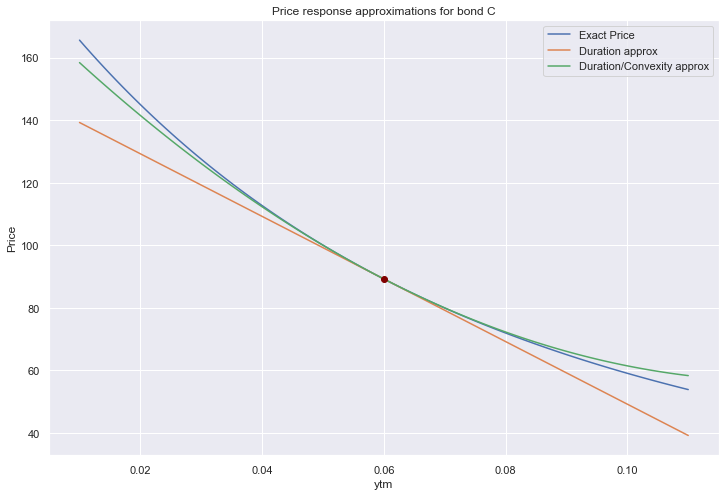

In [199]:
ytm = 0.06
delta_bps = 500/10000 # rozważymy obszar 6% +/-500bps
ytm_range = np.linspace(start = ytm-delta_bps, stop = ytm+delta_bps, num = 100)
reference_price = C.price(ytm)
MD = C.MD(ytm)
convexity = C.C(ytm)

price_exact = [C.price(ytm_) for ytm_ in ytm_range]
duration_approx = [reference_price - MD*(ytm_-ytm)*reference_price for ytm_ in ytm_range]
duration_convexity_approx = [reference_price - MD*(ytm_-ytm)*reference_price + 0.5*convexity*(ytm_-ytm)**2*reference_price for ytm_ in ytm_range]

Approximation_DataFrame = pd.DataFrame({'ytm':ytm_range,'Exact Price':price_exact, 'Duration approx': duration_approx, 'Duration/Convexity approx':duration_convexity_approx})
Approximation_DataFrame.set_index('ytm',inplace =True)
Approximation_DataFrame.plot()
plt.scatter(ytm, reference_price, color = 'maroon',zorder =4)
plt.ylabel('Price')
plt.xlabel('ytm')
_=plt.title("Price response approximations for bond C")

----------
## Konstrukcja portfela

Naszym zadaniem jest użycie obligacji **A,B,C** do konstrukcji portfela o własnościach:
* bezkosztowy
* $MD = 0$
* $C>0$  

Korzystając z obliczonych wcześniej parametrów obligacji:

| Obligacja | Cena | MD | C |
|:-:|:-:|:-:|:-:|
|A | 94.50| 1.86 | 5.23 |
|B | 88.84| 5.84 | 42.22 |
|C | 89.17| 11.23 | 171.90 |

Oznaczmy wektory:
* $w$ - pozycji w obligacjach
* $p$ - cen obligacji
* $MD$ - modified duration obligacji
* $C$ - convexity obligacji


Dla stałego $ytm$, możemy zapisać $MD$ oraz $C$ portfela jako ważone średnie $MD$ oraz $C$ poszczególnych pozycji. Pozwala nam to zapisać następujące równania w celu wyznaczenia $w$:

$$\sum_{i=1}^{3}w_ip_i = 0$$

$$\sum_{i=1}^{3}w_iMD_i = 0$$

$$\sum_{i=1}^{3}w_iC_i >0.$$


Rozwiązując pierwsze dwa równania ze względu na $w_2$ oraz $w_3$ otrzymujemy:

$$w_3 = -\frac{w_1p_1+w_2p_2}{p_3}$$

$$w_2 = -w_1\cdot\frac{D_1-\frac{p_1}{p_3}D_3}{D_2-\frac{p_2}{p_3}D_3}.$$

Parametrem $w_1$ możemy natomiast manewrować w celu uzyskania dodatniej convexity. Ustalmy go jako $w_1 = 1$, co prowadzi do spełnienia warunków.

In [212]:
# Wartości cen, MD i C dla komponentów
p = np.array([Bond.price(ytm) for Bond in Bonds])
MD = np.array([Bond.MD(ytm) for Bond in Bonds])
C = np.array([Bond.C(ytm) for Bond in Bonds])

#Obliczanie wag
w1 = 1
w2 = -1*(MD[0]-p[0]/p[2]*MD[2])/(MD[1]-p[1]/p[2]*MD[2])
w3 = -(w1*p[0]+w2*p[1])/p[2]
w = np.array([w1,w2,w3])
pd.DataFrame({'Bond':['A','B','C'], 'weight':w})

,Bond,weight
0,A,1.000000
1,B,-1.876902
2,C,0.810062


In [220]:
# Wartość, MD i C portfela
V_p = w.dot(p).round(2)
MD_p = w.dot(MD).round(2)
C_p = w.dot(C).round(2)

pd.DataFrame({'Parameter':['V_p','MD_p','C_p'],'value': [V_p, MD_p, C_p]})

,Parameter,value
0,V_p,0.00
1,MD_p,-0.00
2,C_p,65.24


------
## Reakcja portfela na zmiany *ytm*

Pokażemy zależność wartości portfela jako funkcji *ytm*. Ponieważ portfel ma wartość $0$, będziemy operować na jego składnikach, których zmiany wartości policzymy i zsumujemy.

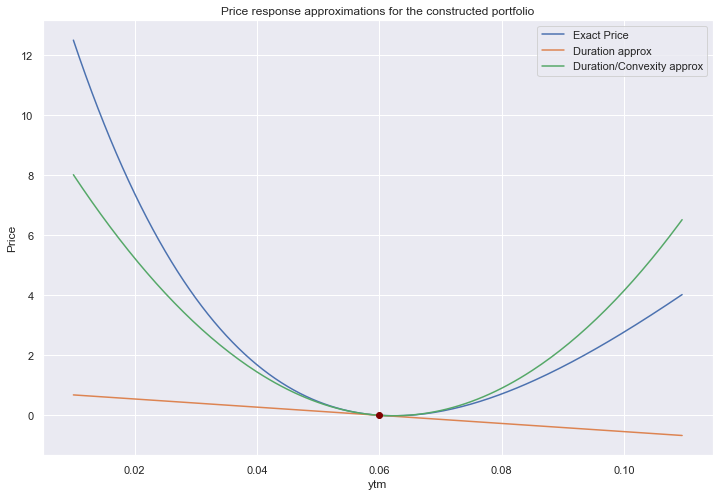

In [260]:
ytm = 0.06
delta_bps = 500/10000 # rozważymy obszar 6% +/-500bps
d_ytm = 2*delta_bps/200
ytm_range = np.arange(start = ytm-delta_bps, stop = ytm+delta_bps, step = d_ytm).round(4)

portfolio_price_exact = np.zeros_like(ytm_range)
portfolio_duration_approx = np.zeros_like(ytm_range)
portfolio_duration_convexity_approx = np.zeros_like(ytm_range)


for ind,Bond in enumerate(Bonds):
    reference_price = Bond.price(ytm)
    MD = Bond.MD(ytm)
    convexity = Bond.C(ytm)

    price_exact = np.array([Bond.price(ytm_) for ytm_ in ytm_range])
    duration_approx = np.array([reference_price - MD*(ytm_-ytm)*reference_price for ytm_ in ytm_range])
    duration_convexity_approx = np.array([reference_price - MD*(ytm_-ytm)*reference_price + 0.5*convexity*(ytm_-ytm)**2*reference_price for ytm_ in ytm_range])

    portfolio_price_exact = portfolio_price_exact + w[ind]*price_exact
    portfolio_duration_approx = portfolio_duration_approx + w[ind]*duration_approx
    portfolio_duration_convexity_approx = portfolio_duration_convexity_approx + w[ind]*duration_convexity_approx
    
Portfolio_Approximation_DataFrame = pd.DataFrame({'ytm':ytm_range,'Exact Price':portfolio_price_exact, 'Duration approx': portfolio_duration_approx, 'Duration/Convexity approx':portfolio_duration_convexity_approx})
Portfolio_Approximation_DataFrame.set_index('ytm',inplace =True)
Portfolio_Approximation_DataFrame.plot()
plt.scatter(ytm, V_p, color = 'maroon',zorder =4)
plt.ylabel('Price')
plt.xlabel('ytm')
_=plt.title("Price response approximations for the constructed portfolio")

Widzimy tutaj zachowanie ceny portfela o zerowym *modified duration* i dodatniej *convexity*. Niezależnie od kierunku rozwoju *ytm*, tak skonstruowany portfel będzie zarabiał. Zwracając uwagę na aproksymację Taylora:

$$\Delta P = -MD\cdot\Delta ytm \cdot P +\frac{1}{2}C\cdot(\Delta ytm)^2\cdot P,$$

widzimy, że zerowe *MD* powoduje, że portfel ani nie traci, ani nie zyskuje, ale już dodatnie *C* wymusza zarobek niezależnie od znaku $\Delta ytm$. Dodatkowo dla dużych zmian *ytm* to efekt *convexity* zaczyna przeważać nad efektem *duration* powodując, że wartość portfela staje się dodatnia.

Dla scenariuszy zadanych w zadaniu, tj dla $ytm\pm 75\text{bps}$ otrzymujemy:

In [269]:
delta = 75/10000
scenarios = np.array([ytm-delta,ytm, ytm+delta]).round(4)
Portfolio_Approximation_DataFrame.loc[scenarios]

,Exact Price,Duration approx,Duration/Convexity approx
ytm,,,
0.0525,0.278815,0.101964,0.267121
0.0600,0.000000,0.000000,0.000000
0.0675,0.052435,-0.101964,0.063194
